In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(threshold=None)

# Problem 1 - Gaussian Process Modelling

## Data I/O

In [126]:
X_train = np.genfromtxt('hw3-data/gaussian_process/X_train.csv', delimiter=',')
X_test = np.genfromtxt('hw3-data/gaussian_process/X_test.csv', delimiter=',')
y_train = np.genfromtxt('hw3-data/gaussian_process/y_train.csv', delimiter=',')
y_test = np.genfromtxt('hw3-data/gaussian_process/y_test.csv', delimiter=',')

## Helper Functions

In [127]:
def calculateRMSE(y_pred, y_test):
    n = y_pred.shape[0]
    return np.linalg.norm(y_pred - y_test)/(n**0.5)

## Gaussian Process Regression

In [128]:
class GaussianProcessRegression():
    def __init__(self):
        pass
    
    def standardize(self, y):
        mean = np.mean(y)
        std = np.std(y)
        y = (y - mean)/std
        self.mean = mean
        self.std = std
        return y
    
    def calcKernel(self):
        X = self.X
        (n, d) = X.shape
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                xi, xj = X[i, :].flatten(), X[j, :].flatten()
                k = self.calcRadialDistance(xi, xj)
                K[i, j] = k
                K[j, i] = k
        self.K = K
    
    def transformOutput(self, y):
        y = y*self.std + self.mean
        return y
    
    def calcRadialDistance(self, x1, x2):
        return np.exp(-1*(np.linalg.norm(x1-x2)**2)/self.b)
    
    def train(self, X, y):
        self.X = X
        self.y = self.standardize(y)
    
    def setb(self, b):
        self.b = b
        self.calcKernel()
        
    def predict(self, X_t, sig):
        X = self.X
        y = self.y
        (n, d) = X.shape
        (m, d) = X_t.shape
        
        Kn = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                Kn[i, j] = self.calcRadialDistance(X_t[i, :].flatten(), X[j, :].flatten())
        
        Kn = Kn.reshape((m, n))
        K = self.K
        mu = Kn.dot(np.linalg.inv((sig)*np.identity(n) + K)).dot(y)
        
        #cov = (sig**2) + 1 - Kn.dot(np.linalg.inv((sig**2)*np.identity(n) + K)).dot(Kn.T)
        return self.transformOutput(mu)   
               

In [129]:
GPR = GaussianProcessRegression()

In [130]:
GPR.train(X_train, y_train)

## RMSE vs. (b, $\sigma^2$)

In [131]:
b_tests = [5, 7, 9, 11, 13, 15]
sig_tests = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [132]:
results = np.zeros((len(b_tests), len(sig_tests)))

In [133]:
for i in range(len(b_tests)):
    GPR.setb(b_tests[i])
    for j in range(len(sig_tests)):
        y_pred = GPR.predict(X_test, sig_tests[j])
        results[i, j] = calculateRMSE(y_pred, y_test)

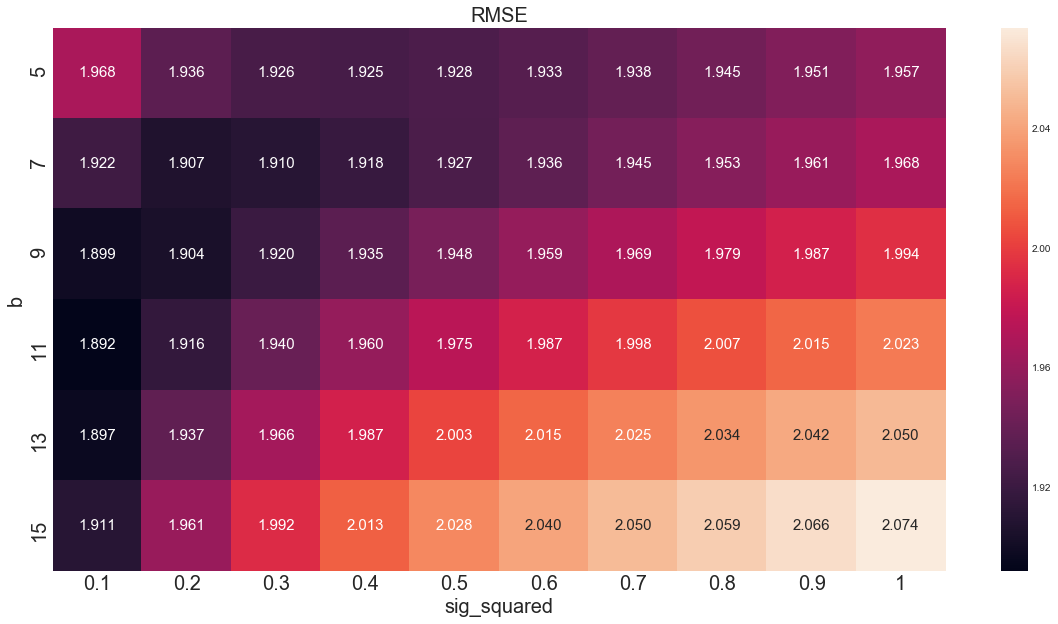

In [134]:
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
sns.heatmap(results, annot=True, annot_kws={"size": 15}, fmt='.3f', xticklabels=sig_tests, yticklabels=b_tests)
plt.xlabel('sig_squared', fontsize=20)
plt.ylabel('b', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('RMSE', fontsize=20)
plt.savefig('1b.png')
plt.show()

## Prediction using only a single dimension - (car weight)

In [135]:
(n, d) = X_train.shape
X_test_f4 = X_train[:, 3].reshape(n, 1)

In [136]:
for i in range(d-1):
    X_test_f4 = np.column_stack((X_test_f4, X_train[:, 3].reshape((n, 1))))

In [137]:
GPR.setb(5)
y_test_f4 = GPR.predict(X_test_f4, 2)

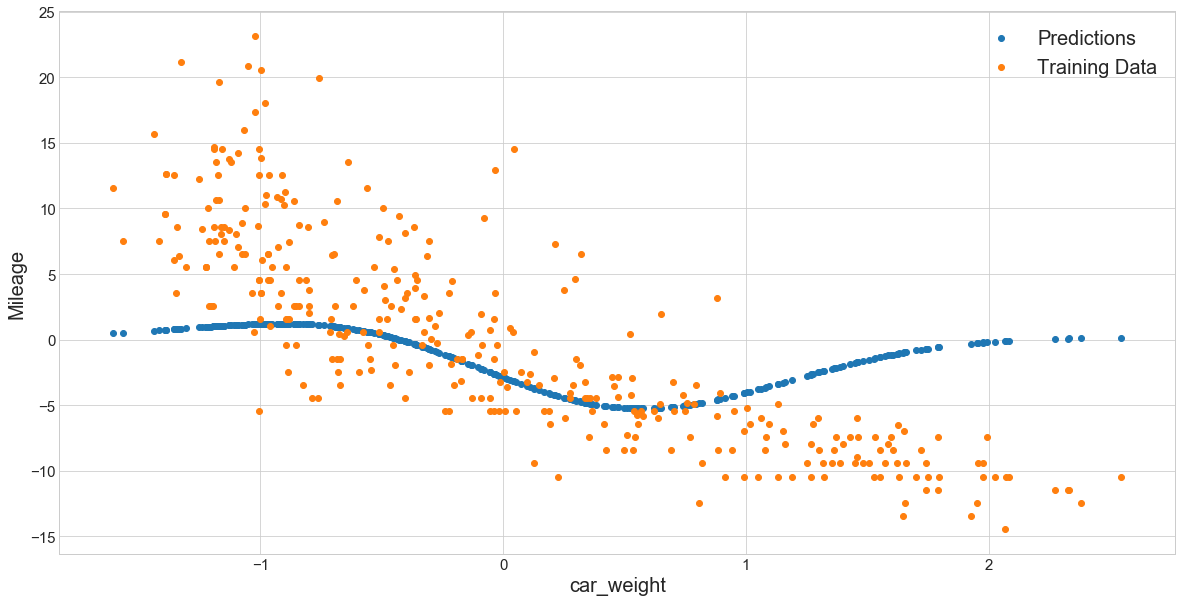

In [138]:
plt.figure(figsize=(20, 10))
plt.scatter(X_train[:, 3], y_test_f4, label="Predictions")
plt.scatter(X_train[:, 3], y_train, label="Training Data")
plt.xlabel("car_weight", fontsize=20)
plt.ylabel("Mileage", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('1c.png')
plt.show()

In [142]:
GPR_x4 = GaussianProcessRegression()
GPR_x4.train(X_train[:, 3].reshape(X_train.shape[0], 1), y_train)
GPR_x4.setb(5)
y_train_f4 = GPR_x4.predict(X_train[:, 3].reshape(X_train.shape[0], 1), 2)

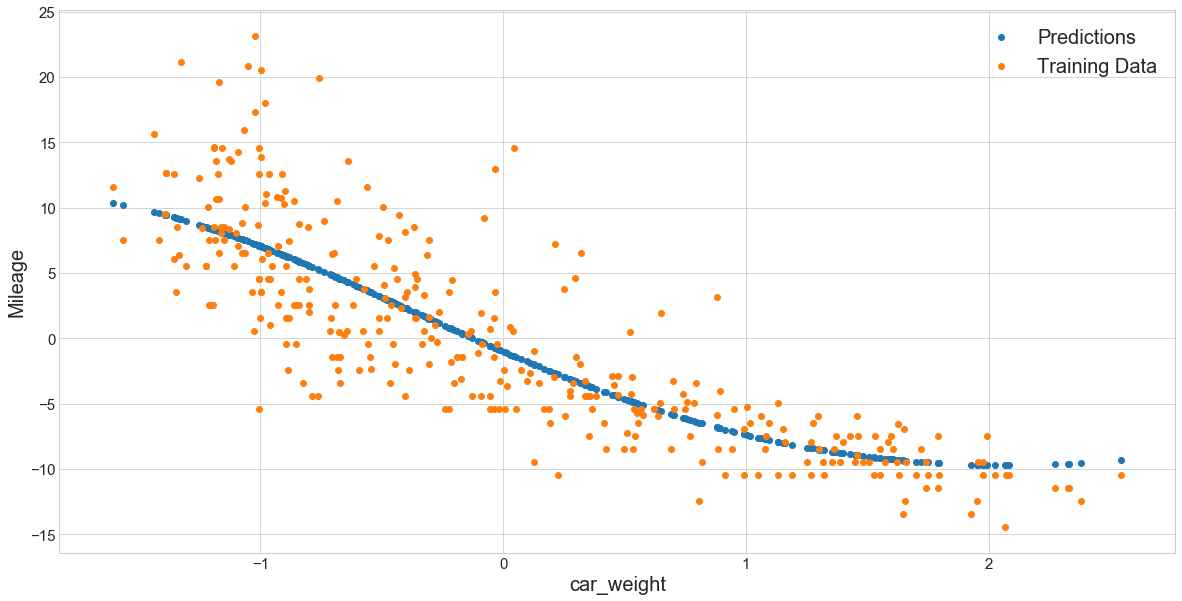

In [147]:
plt.figure(figsize=(20, 10))
plt.scatter(X_train[:, 3], y_train_f4, label="Predictions")
plt.scatter(X_train[:, 3], y_train, label="Training Data")
plt.xlabel("car_weight", fontsize=20)
plt.ylabel("Mileage", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('1d_new.png')
plt.show()

# Problem 2 - Boosting

## Data I/O

In [62]:
X_train = np.genfromtxt('hw3-data/boosting/X_train.csv', delimiter=',')
X_test = np.genfromtxt('hw3-data/boosting/X_test.csv', delimiter=',')
y_train = np.genfromtxt('hw3-data/boosting/y_train.csv', delimiter=',')
y_test = np.genfromtxt('hw3-data/boosting/y_test.csv', delimiter=',')

In [63]:
X_train_w_ones = np.column_stack((X_train, np.ones(X_train.shape[0])))
X_test_w_ones = np.column_stack((X_test, np.ones(X_test.shape[0])))

## Helper Functions

In [64]:
def calculateAccuracy(predictions, ground_truth):
    n = predictions.shape[0]
    assert n == ground_truth.shape[0]
    return y_pred[y_pred==ground_truth].shape[0]/n

def calculateErrorRate(predictions, ground_truth):
    n = predictions.shape[0]
    assert n == ground_truth.shape[0]
    return np.sum(y_pred!=ground_truth)/n

## Least Square Classifier

In [65]:
class LeastSquareClassifier():
    def __init__(self):
        self.weights = None
    
    def train(self, X, y):
        (n, d) = X.shape
        XTX = X.T.dot(X)
        w = np.linalg.inv(XTX).dot(X.T).dot(y)
        assert w.shape[0] == d
        self.weights = w
        
    def test(self, X):
        w = self.weights
        (n, d) = X.shape
        y_int = X.dot(w)
        return y_int/np.abs(y_int)

In [66]:
LSClassifier = LeastSquareClassifier()

In [67]:
LSClassifier.train(X_train_w_ones, y_train)

In [68]:
y_pred = LSClassifier.test(X_test_w_ones)

In [69]:
print("Basic Least Square Classifier Accuracy: {}".format(calculateAccuracy(y_pred, y_test)))

Basic Least Square Classifier Accuracy: 0.987


## Boosted Least Square Classifier

In [70]:
class BoostedLeastSquareClassifier():
    def __init__(self, classifier):
        self.classifier = classifier
        self.classifiers = []
        self.alphas = None
        self.eps = None
        self.training_errors = None
        self.testing_errors = None
        self.weights = None
        self.sample_tracker = []
        
        
    def train(self, X, y, num_of_classifiers):
        
        np.random.seed(0)
        
        self.training_errors = []
        
        eps = np.zeros(num_of_classifiers)
        self.alphas = np.zeros(num_of_classifiers)
        
        (n, d) = X.shape
        
        w = np.ones(n)/n
        
        y_pred_int = np.zeros(n)
        
        for i in range(num_of_classifiers):

            c = self.classifier()
            
            sample_indices = np.random.choice(n, size=n, replace=True, p=w)
            self.sample_tracker.extend(list(sample_indices))
            X_sample = X[sample_indices,:]
            y_sample = y[sample_indices]
            
            c.train(X_sample, y_sample)
            
            y_pred = c.test(X)
            
            e = float(np.dot(w[y_pred!=y], np.ones(n)[y_pred!=y]))
            
            if(e>0.5):
                w_int = c.weights
                w_int = -1*w_int
                c.weights = w_int
                y_pred = c.test(X)
                e = float(np.dot(w[y_pred!=y], np.ones(n)[y_pred!=y]))
                
            eps[i] = e
            
            a = 0.5*np.log(((1-e)/e))
            self.alphas[i] = a
            
            y_pred_int = y_pred_int + (self.alphas[i]*y_pred)
            y_pred_final = y_pred_int/np.abs(y_pred_int)
            
            self.training_errors.append(np.sum(y_pred_final != y)/ n)
            
            w = w*(np.exp(-a*y*y_pred))

            w = (w/np.sum(w))

            self.classifiers.append(c)
            
        self.eps = eps
            
        
    def test(self, X, y, num_of_classifiers=None):
        (n, d) = X.shape
        if num_of_classifiers == None:
            num_of_classifiers = self.alphas.shape[0]
        self.testing_errors = []
        y_pred_int = np.zeros(n)
        
        for i in range(num_of_classifiers):
            c = self.classifiers[i]
            y_pred = c.test(X)
            y_pred_int = y_pred_int + (self.alphas[i]*y_pred)
            y_pred_final = y_pred_int/np.abs(y_pred_int)
            self.testing_errors.append(np.sum(y_pred_final != y)/ n)
        return y_pred_final        
            
            

In [27]:
BLSClassifier = BoostedLeastSquareClassifier(LeastSquareClassifier)

In [28]:
BLSClassifier.train(X_train_w_ones, y_train, 1500)

In [29]:
y_pred = BLSClassifier.test(X_test_w_ones, y_test)

In [71]:
print("Boosted Least Square Classifier Accuracy: {}".format(calculateAccuracy(y_pred, y_test)))

Boosted Least Square Classifier Accuracy: 0.987


## Plot of Training Error vs. Testing Error

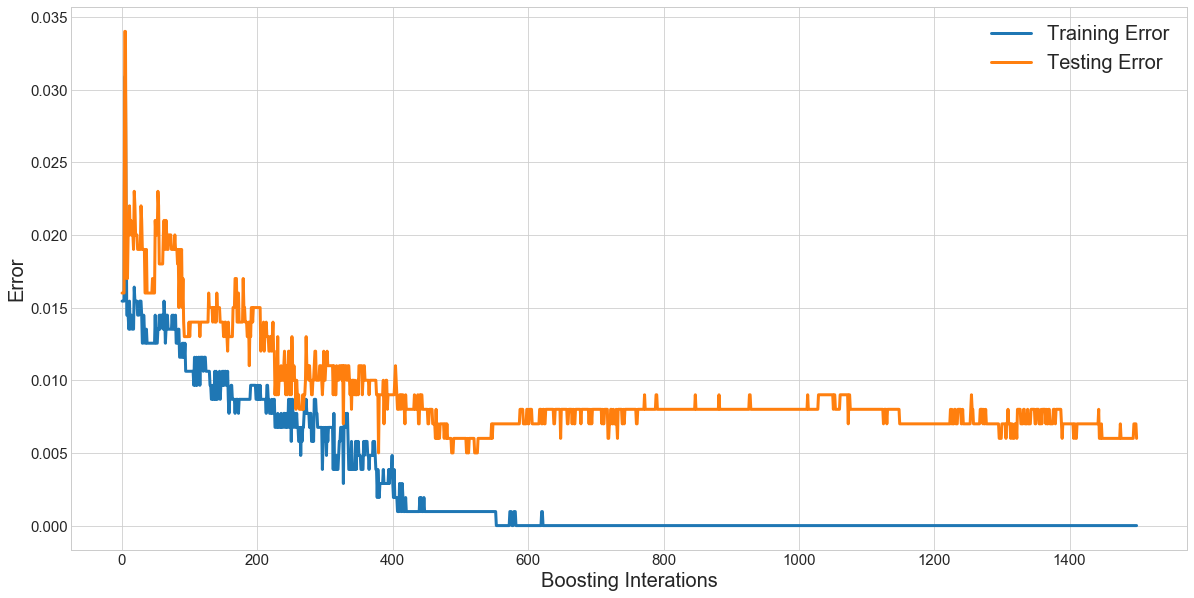

In [78]:
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
plt.plot(BLSClassifier.training_errors, label="Training Error", linewidth=3)
plt.plot(BLSClassifier.testing_errors, label="Testing Error", linewidth=3)
plt.legend(fontsize=20)
plt.xlabel("Boosting Interations", fontsize=20)
plt.ylabel("Error", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('2a.png')
plt.show()

## Plot of Training Error vs. Theoritical Upper Bound

In [73]:
def calculateUpperBound(errors):
    prod = 1
    t = errors.shape[0]
    upper_bound = []
    for i in range(t):
        e = errors[i]
        prod *= np.exp(-2*((0.5-e)**2))
        upper_bound.append(prod)
    return np.array(upper_bound)

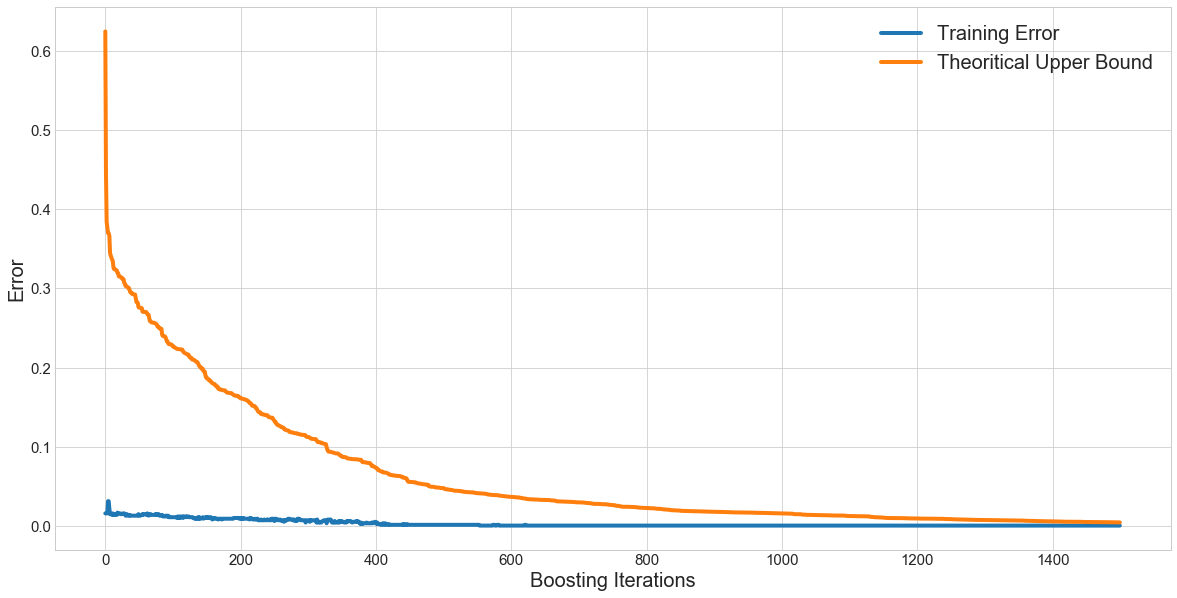

In [79]:
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
plt.plot(BLSClassifier.training_errors, label="Training Error", linewidth=4)
plt.plot(calculateUpperBound(BLSClassifier.eps), label="Theoritical Upper Bound", linewidth=4)
plt.legend(fontsize=20)
plt.xlabel("Boosting Iterations", fontsize=20)
plt.ylabel("Error", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('2b.png')
plt.show()

## Histogram of number of times each data is sampled

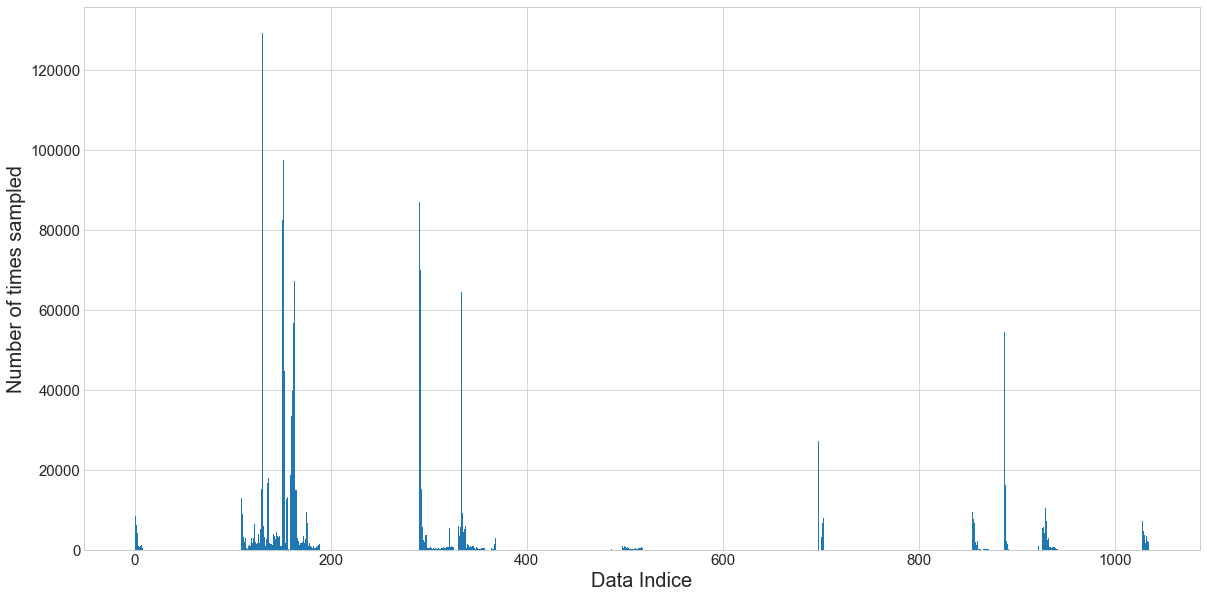

In [75]:
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
plt.hist(BLSClassifier.sample_tracker, bins=1036, label="Sampling Histogram")
plt.xlabel("Data Indice", fontsize=20)
plt.ylabel("Number of times sampled", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('2c.png')
plt.show()

In [90]:
sample_tracker = np.array(BLSClassifier.sample_tracker)
sample_tracker[sample_tracker==0].shape

(8442,)

In [95]:
freq = np.zeros(1036)
for i in BLSClassifier.sample_tracker:
    freq[i] += 1

<Container object of 3 artists>

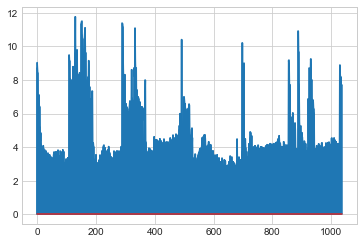

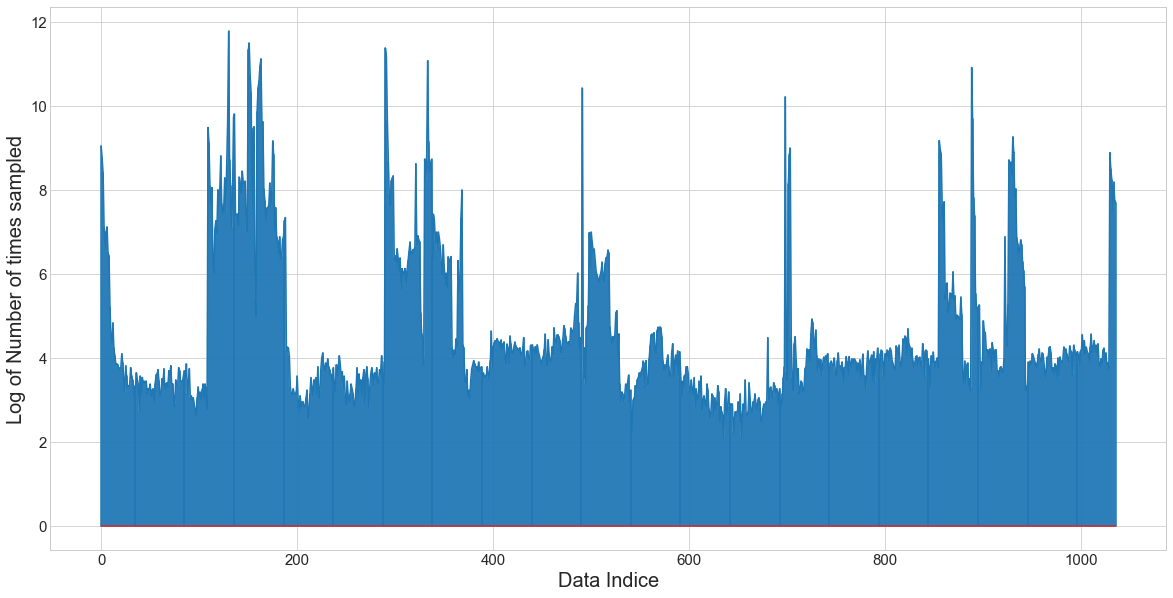

In [104]:
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
plt.stem(np.log(freq), markerfmt='', label='Sampling Histogram')
plt.xlabel("Data Indice", fontsize=20)
plt.ylabel("Log of Number of times sampled", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('2c_log.png')
plt.show()

## Plot of $\alpha_t$ and $\epsilon_t$ for each classifier

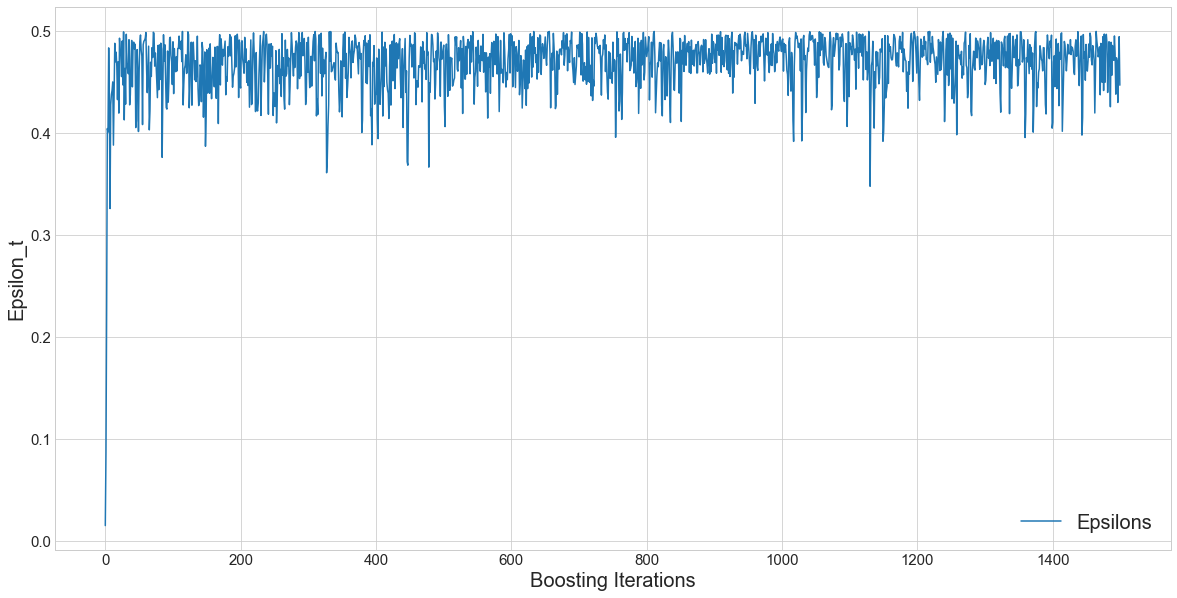

In [80]:
plt.rc("text", usetex=False)
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
plt.plot(BLSClassifier.eps, label="Epsilons")
plt.xlabel("Boosting Iterations", fontsize=20)
plt.ylabel("Epsilon_t", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('2de.png')
plt.show()

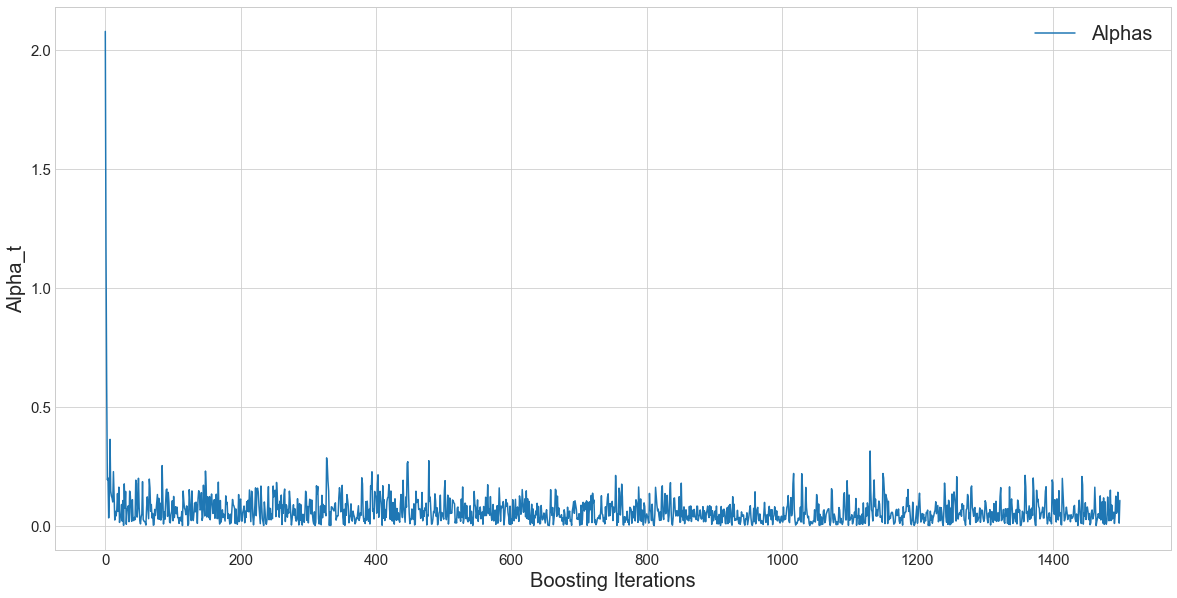

In [81]:
plt.rc("text", usetex=False)
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')
plt.plot(BLSClassifier.alphas, label="Alphas")
plt.xlabel("Boosting Iterations", fontsize=20)
plt.ylabel("Alpha_t", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('2da.png')
plt.show()